In [ ]:
  """ Setup """

!pip install medmnist

import medmnist
from medmnist import INFO, Evaluator

import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

import torchvision.datasets as datasets
from torchvision import transforms

%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
""" HyperParameters """

n_epochs = 1
batch_size_train = 8
batch_size_test = 10
learning_rate = 0.01
momentum = 0.5
log_interval = 1000
p_dropout = 0.3

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

retina_mnist = True
show = True

In [ ]:
""" Datasets """

# RetinaMNIST
if retina_mnist:

  info = INFO['retinamnist']
  DataClass = getattr(medmnist, info['python_class'])

  # preprocessing
  data_transform = transforms.Compose([transforms.ToTensor()])
  # load the data
  train_dataset = DataClass(split='train', transform=data_transform, download=True)
  test_dataset = DataClass(split='test', transform=data_transform, download=True)

  # encapsulate data into dataloader form
  train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
  test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=False)

# MNIST
else:
  train_loader = DataLoader(
      datasets.MNIST('/files/', 
                    train=True, 
                    download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()
                        #  transforms.Normalize((0.1307,), (0.3081,))
                        ])),
                    batch_size=batch_size_train, 
                    shuffle=True
                            )
  test_loader = DataLoader(
      datasets.MNIST('/files/', 
                    train=False, 
                    download=True,
                    transform=transforms.Compose([
                          transforms.ToTensor()
                          # transforms.Normalize((0.1307,), (0.3081,))
                          ])),
                    batch_size=batch_size_test, 
                    shuffle=True
                          )

Failed download. Trying https -> http instead. Downloading http://zenodo.org/record/6496656/files/retinamnist.npz?download=1 to /root/.medmnist/retinamnist.npz


100%|██████████| 3291041/3291041 [00:06<00:00, 478424.38it/s]

Using downloaded and verified file: /root/.medmnist/retinamnist.npz



Length trainset: 135,
Length testset: 40,
One test data batch is a tensor of shape: torch.Size([10, 3, 28, 28]),



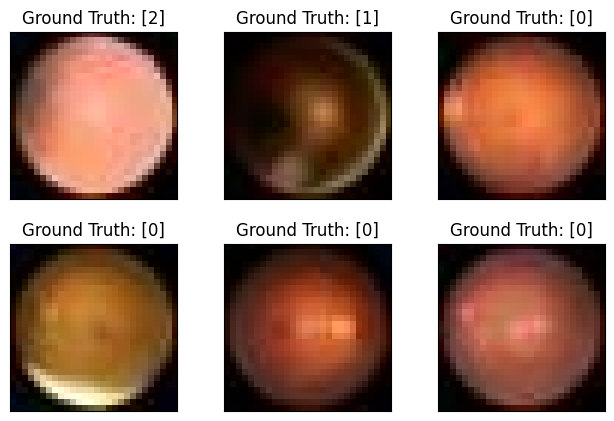

In [ ]:
""" Dataset Visualization """

examples = enumerate(test_loader)
_, (example_data, example_targets) = next(examples)


print(f'''
Length trainset: {len(train_loader)},
Length testset: {len(test_loader)},
One test data batch is a tensor of shape: {example_data.shape},
''')

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i].permute(1,2,0).numpy(), interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i].numpy()))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [ ]:
""" Build Network """

class FCNet_512(nn.Module):
    
    def __init__(self, in_size, hdim, out_size):
        super(FCNet_512, self).__init__()

        self.fc1 = nn.Linear(in_size, hdim) 
        self.fc2 = nn.Linear(hdim, out_size) 

    def forward(self, x):
        
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(h))
        
        return out


In [ ]:
""" Initialize Network """

# compute input size, hidden dimension and output size
_, (example_data, example_targets) = next(enumerate(test_loader))
print(f'data.shape: {example_data.shape}')
print(f'labels.shape: {example_targets.shape}')

in_size = np.prod(np.array(example_data[0].shape))
out_size = 5
hdim = 512
layer_dims = [in_size, hdim, out_size]

net_512 = FCNet_512(*layer_dims)

optimizer = optim.SGD(net_512.parameters(), 
                      lr=learning_rate,
                      momentum=momentum)
criterion = nn.CrossEntropyLoss()

summary(FCNet_512(*layer_dims), input_size=(in_size,))

data.shape: torch.Size([10, 3, 28, 28])
labels.shape: torch.Size([10, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,204,736
            Linear-2                    [-1, 5]           2,565
Total params: 1,207,301
Trainable params: 1,207,301
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 4.61
Estimated Total Size (MB): 4.62
----------------------------------------------------------------


<ipython-input-12-5621d6d6790f>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.fc2(h))


In [ ]:
""" Training """

def train(net, epoch, optimizer):
  net.train()
  train_loss = 0
  train_acc = 0
  grads = {}
  params = {}

  for batch_idx, (data, target) in enumerate(train_loader):
    target = target.view(-1)
    optimizer.zero_grad()
    output = net(data)
    loss = criterion(output, target)
    loss.backward()
    

    # compute and store gradients
    for index, param in enumerate(net.parameters()):
        if param.grad is not None:
          grads_current = param.grad.data.view(-1).clone().cpu()
          if index%2 == 0:
            suff = 'w'
            # I want the gradients to be matrices
            grads_current = grads_current.reshape(layer_dims[index//2], layer_dims[index//2+1])
            grads[f'Layer_{index//2}_{suff}'] = grads_current
          else:
            suff = 'b'
            grads[f'Layer_{index//2}_{suff}'] = grads_current
          params[f'Layer_{index//2}_{suff}'] = param


    # ATTENTION, ILLEGAL !!!
    # we will delete this part once "algo_B1" starts working
    # compute 'small_g' gradients (after softmax)
    for index, sample_class in enumerate(target):
      output[index][sample_class] += -1
    small_grads = output


    # stop after the first batch
    break

    # theoretically useless
    optimizer.step()
    train_loss = loss.item()
    pred = output.data.max(1, keepdim=True)[1]
    train_acc += pred.eq(target.data.view_as(pred)).sum()
    
  return grads, small_grads, params, train_loss, train_acc


In [ ]:
""" Testing """

def test(net):
  net.eval()
  test_loss = 0
  test_acc = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = net(data)
      test_loss += criterion(output, target)
      pred = output.data.max(1, keepdim=True)[1]
      test_acc += pred.eq(target.data.view_as(pred)).sum()
  
  return test_loss/len(test_loader), test_acc

In [ ]:
""" Run """

for epoch in range(1, n_epochs+1):

  # ATTENTION for the small_grads !!! 
  # I used the target labels which we are not supposed to know !!! 
  # we should get 'small_grads' from something like:
  """ small_grads, labels = algo_B1(grads) """
  # compute grads (G) and small_grads (g) from training
  grads, small_grads, params, _, _ = train(net=net_512, epoch=epoch, optimizer=optimizer)


  # nice print grads' shape
  if show:
    print(f'small_grads[0]: \n{small_grads[0]}')
    print(f"small_grads size: {small_grads.shape}")
    print('\nGrad Sizes:')
    for index, key in enumerate(grads.keys()):
      print(f'{key}: {grads[key].size()}')
    print('\nParam Sizes:')
    for index, key in enumerate(grads.keys()):
      print(f'{key}: {params[key].size()}')

print('\n---- Finished Training Batch ----\n')

small_grads[0]: 
tensor([-0.8219,  0.2155,  0.1982,  0.2125,  0.1958],
       grad_fn=<SelectBackward0>)
small_grads size: torch.Size([8, 5])

Grad Sizes:
Layer_0_w: torch.Size([2352, 512])
Layer_0_b: torch.Size([512])
Layer_1_w: torch.Size([512, 5])
Layer_1_b: torch.Size([5])

Param Sizes:
Layer_0_w: torch.Size([512, 2352])
Layer_0_b: torch.Size([512])
Layer_1_w: torch.Size([5, 512])
Layer_1_b: torch.Size([5])

---- Finished Training Batch ----



<ipython-input-12-5621d6d6790f>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.fc2(h))


In [ ]:
def attack_nn(gradients, Ind_ExANs_H, small_grads):
  """ Run the attack algorithm """
  labels, small_grads = algo_B1(gradients)
  activation_patterns = algo_B3(gradients, Ind_ExANs_H, small_grads)
  return activation_patterns
  
attack_nn(grads)

In [ ]:
def find_duplicate_indices(r_c, tol=0.00000001):
  count = 0
  Indices_batch = {}
  for loop_i in range(r_c.shape[0]):
    if r_c[loop_i] != float('inf'):
      min_val = r_c[loop_i] - tol
      max_val = r_c[loop_i] + tol
      indices = np.where((r_c >= min_val) & (r_c <= max_val) & (r_c != float('inf')))
      if len(indices[0]) > 1:
        Indices_batch[count] = indices[0]
        count += 1
        r_c[indices[0]] = float('inf')

  return Indices_batch



In [ ]:
"""   B.1 Algorithm

Input: The gradient of (the weight the last hidden layer W_H), which is G_H_bar

Output: Reconstructed labels,
        loss vectors 'small_grads'
"""

def algo_B1(grads):
    # The last Hidden layer
    # Our FCN has only one hidden layer, its size is 512
    # And the gradient should be the before the FC1+ReLU which should be 2352 x 512 (The input layer size * hidden layer size)
    G_H_bar = grads['Layer_0_w'].T
    # print(f'G_H_bar has size: {G_H_bar.size()}')

    # For RetinaMNIST there are 5 classes
    nr_of_classes = out_size


    # r_c c=1 to K
    r = []

    # Compute ration vector r_c = [G_H_bar]_c / [G_H_bar]_1 for each class

    # For example
    # G_H_bar_1 = G_H_bar[0, :]
    # G_H_bar_2 = G_H_bar[1, :]
    #
    # print(f'G_H_bar_1: {G_H_bar_1}')
    # print(f'G_H_bar_2: {G_H_bar_2}')
    # print(f'G_H_bar_2/G_H_bar_1: {G_H_bar_1/G_H_bar_2}')

    for i in range(nr_of_classes):
        r.append(G_H_bar[i, :]/G_H_bar[0, :])
    # print(f'r_1: {r[0]}')
    # print(f'r_2: {r[1]}')
    # print(f'r_1 has size {r[0].size()}')

    # The disjoint index groups
    # I_m for I_1, I_2 to I_8

    # !!! Find all duplicates in r_2
    # and group them by the duplicated value
    I = find_duplicate_indices(r[1])
    print(f'Estimated M is {len(I.keys())}')

    # sample-wise
    ratio_gcm_g1m = [[] for _ in range(batch_size_train)]

    # Get all values of g_c_m_bar / g_1_m_bar
    for c in range(nr_of_classes):
        for m in range(batch_size_train):
            # :/
            try:
              j = random.choice(I[m].tolist())
              ratio_gcm_g1m[m].append(r[c][j])
            except:
              pass

    # Upper bound delta_m, sample-wise
    Deltas = []
    # Final output g_c_m, sample-wise
    g_c_m = []


    for m in range(batch_size_train):
        # assume g_1_m is positive according to Remark 2 on page 6
        print(ratio_gcm_g1m[m])
        Y_m = algo_B2(ratio_gcm_g1m[m])

        Delta_m = 1 / ratio_gcm_g1m[Y_m]
        Deltas.append(Delta_m)

        g_1_m = 2 * Delta_m / 3

        g_c_m.append([ratio * g_1_m for ratio in ratio_gcm_g1m[m]])

    return Y_m, g_c_m

algo_B1(grads)

Indices_batch:
 {0: array([ 150,  224,  228,  689,  714,  861,  963, 1110, 1130, 1208, 1281,
       1589, 1992, 2016, 2037, 2090, 2296]), 1: array([ 161,  219,  366,  409,  430,  513,  528,  660, 1395, 1522, 1525,
       1542, 1588, 1689, 2130, 2268, 2341]), 2: array([167, 977]), 3: array([167, 977]), 4: array([ 225, 2283]), 5: array([ 469, 2086]), 6: array([ 471, 2088]), 7: array([1181, 1184, 1520, 1768])}
Estimated M is 8
[tensor(nan), tensor(inf), tensor(-inf), tensor(-inf), tensor(inf)]


NameError: ignored

In [ ]:
"""   B.2 Algorithm

Input: loss vector for the m-th sample 'small_grads' from 'algo_B1'

Output: Reconstructed labels
"""

# small grads is a (batch_size, 5) matrix
# the goal is to find the position of the negative element in each row

def algo_B2(small_grads):
  return np.where(small_grads < 0)[1]


In [ ]:
algo_B2(small_grads)

array([1, 0, 2, 0, 0, 2, 0, 2])

In [ ]:
"""   B.3 Algorithm 

Input: Gradients weights, layer wise,
       Index sets of ExAN at last ReLU,
       Reconstructed loss vector for the m-th sample 'small_grads' from 'algo_B1'

Output: Reconstructed attivation pattern

"""
# we need grads as matrices, non as lists

# grads for B3, only weights-wise

# Ind_ExANs is m-th sample wise
def algo_B3(grads, Ind_ExANs_H=None, small_grads=None):
  grads = np.array([grads['Layer_0_w'], grads['Layer_1_w']])
  H = grads.shape[0]
  I_cur = Ind_ExANs_H

  # Ugly as hell
  # we should find a better way to store the activation patterns
  D_pats = []
  for h in range(H):
    D_pats.append(np.zeros((batch_size_train, layer_dims[h+1], layer_dims[h+1])))


  for i in range(H-1, 0, -1):
    for m in range(2):
      # choose a random element j from I_cur[m]
      j_exan = random.choice(np.where(I_cur[m] > 0.)[0])
      # store the non-zero grads corresponding to the index of an ExAN
      D_pats[i-1][m] = np.diag(grads[i-1][j_exan,:])   
    
    # construct the index set I_cur from D_pats
  
  ####################################
  # solve binary equation for D_H^m

  small_grads = small_grads
  W_H = params['Layer_1_w']
  D_H = D_pats[-1]
  I_dH = ''
  grad_bias = grads['Layer_0_b']

  """
  mean_sample(sum_classes(small_grads @ W_H @ D_H @ I_dH)) - grad_bias = 0
  eq = 0
  """
  eq = np.mean(np.sum(small_grads @ W_H @ D_H @ I_dH, axis=1), axis=1) - grad_bias

  ###################################
  return D_pats 



